# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import os
import ffn as ffn
import bt

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
plt.style.use
%matplotlib inline

import hvplot.pandas
import yfinance as yf
import seaborn as sns
import monthly_returns_heatmap as mrh

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation

import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension("plotly")
import plotly.graph_objects as go

/Users/pdorisca/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


/Users/pdorisca/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# Select Investment Style: Active/Passive

# 1. Data Access and Cleaning

## Download index for SPY and Factors ETF (Value, Momentum, Quality, Growth/High Dividend, Low Vol)

In [2]:
#download index price
stocks = ["FDL","IVE","IVW","MTUM","QUAL","SPY","USMV", "SIZE"]
end_date = datetime.now()
start_date = end_date + timedelta(-365 * 20)
data = yf.download(stocks, start=start_date, end=end_date)
data.head()

[*********************100%***********************]  8 of 8 completed


Adj Close                                                        \
                 FDL        IVE        IVW MTUM QUAL SIZE         SPY USMV   
Date                                                                         
2000-08-22       NaN  40.029903  68.374657  NaN  NaN  NaN  102.734703  NaN   
2000-08-23       NaN  39.970325  68.967888  NaN  NaN  NaN  103.140663  NaN   
2000-08-24       NaN  39.751896  69.537399  NaN  NaN  NaN  103.461136  NaN   
2000-08-25       NaN  39.851204  69.383141  NaN  NaN  NaN  103.418442  NaN   
2000-08-28       NaN  40.099403  69.810287  NaN  NaN  NaN  103.770996  NaN   

           Close             ...       Open      Volume                    \
             FDL        IVE  ...        SPY USMV    FDL    IVE   IVW MTUM   
Date                         ...                                            
2000-08-22   NaN  63.000000  ...  150.56250  NaN    NaN   3900  1800  NaN   
2000-08-23   NaN  62.906250  ...  149.81250  NaN    NaN  26000  9900  NaN   
2000-08-24   NaN  62.562500  ...  151.15625  NaN    NaN   2500  6900  NaN   
2000-08-25   NaN  62.718750  ...  151.15625  NaN    NaN  21100  3000  NaN   
2000-08-28   NaN  63.109375  ...  151.25000  NaN    NaN  22100  2900  NaN   

                                    
           QUAL SIZE      SPY USMV  
Date                                
2000-08-22  NaN  NaN  3075300  NaN  
2000-08-23  NaN  NaN  5483200  NaN  
2000-08-24  NaN  NaN  4529000  NaN  
2000-08-25  NaN  NaN  2822200  NaN  
2000-08-28  NaN  NaN  5518700  NaN  

[5 rows x 48 columns]

In [3]:
#funds dataframe
funds_df = data['Close'].dropna()
funds_df.tail()

FDL         IVE         IVW        MTUM        QUAL  \
Date                                                                    
2020-08-11  27.280001  115.930000  224.470001  138.080002  103.000000   
2020-08-12  27.389999  116.779999  228.750000  141.820007  104.290001   
2020-08-13  27.160000  115.879997  229.119995  142.559998  104.040001   
2020-08-14  27.200001  116.180000  228.899994  142.449997  103.989998   
2020-08-17  27.120001  115.879997  230.250000  145.039993  104.309998   

                 SIZE         SPY       USMV  
Date                                          
2020-08-11  94.779999  332.799988  63.669998  
2020-08-12  95.410004  337.440002  64.320000  
2020-08-13  95.120003  336.829987  64.199997  
2020-08-14  95.209999  336.839996  64.209999  
2020-08-17  95.449997  337.920013  64.510002

In [4]:
#return dataframe
funds_return = funds_df.pct_change().dropna()
funds_return.tail(10)

FDL       IVE       IVW      MTUM      QUAL      SIZE  \
Date                                                                     
2020-08-04  0.005285  0.005420  0.002228  0.004086  0.003663  0.003129   
2020-08-05  0.000376  0.005391  0.007202  0.001473  0.009764  0.008819   
2020-08-06 -0.000375  0.000088  0.010946  0.003503  0.005958 -0.001599   
2020-08-07  0.015396  0.011866 -0.006767 -0.008308  0.002719  0.005766   
2020-08-10  0.010725  0.009642 -0.001451 -0.007885  0.002421  0.008387   
2020-08-11 -0.001829 -0.002581 -0.011842 -0.020153 -0.005023 -0.002106   
2020-08-12  0.004032  0.007332  0.019067  0.027086  0.012524  0.006647   
2020-08-13 -0.008397 -0.007707  0.001617  0.005218 -0.002397 -0.003040   
2020-08-14  0.001473  0.002589 -0.000960 -0.000772 -0.000481  0.000946   
2020-08-17 -0.002941 -0.002582  0.005898  0.018182  0.003077  0.002521   

                 SPY      USMV  
Date                            
2020-08-04  0.003863  0.004412  
2020-08-05  0.006211 -0.000784  
2020-08-06  0.006685  0.002512  
2020-08-07  0.000718  0.007518  
2020-08-10  0.002989 -0.001088  
2020-08-11 -0.008255 -0.009182  
2020-08-12  0.013942  0.010209  
2020-08-13 -0.001808 -0.001866  
2020-08-14  0.000030  0.000156  
2020-08-17  0.003206  0.004672

# 2. Evaluating passive and active funds

## Analyse historical risk/return of passive vs active funds

We are looking at return and risk characteristic of S&P index, a passive fund, and active funds like Value funds (VL), Momentum funds (MT), Qyality fund (QL), Growth (GR), and High Dividend (HD). Price and return data are daily frequency covering 07/18/2013 to the most recent date. 

In [5]:
#reorder the columns of price dataframe into fund groups
funds_df.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_df = funds_df[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_df.head()

VL-IVE    SC-SIZE    MT-MTUM    LV-USMV     HD-FDL    QL-QUAL  \
Date                                                                           
2013-07-18  79.949997  53.040001  54.110001  33.849998  21.379999  50.150002   
2013-07-19  80.230003  53.040001  54.349998  33.930000  21.430000  49.759998   
2013-07-22  80.400002  54.000000  54.419998  33.939999  21.430000  50.000000   
2013-07-23  80.419998  54.000000  54.330002  33.900002  21.510000  49.919998   
2013-07-24  79.900002  54.000000  54.139999  33.680000  21.360001  49.849998   

               GR-IVW         SPY  
Date                               
2013-07-18  88.529999  168.869995  
2013-07-19  88.500000  169.169998  
2013-07-22  88.660004  169.500000  
2013-07-23  88.339996  169.139999  
2013-07-24  88.250000  168.520004

In [6]:
#reorder the columns of return dataframe into fund groups
funds_return.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_return = funds_return[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_return.head()

VL-IVE  SC-SIZE   MT-MTUM   LV-USMV    HD-FDL   QL-QUAL  \
Date                                                                    
2013-07-19  0.003502   0.0000  0.004435  0.002363  0.002339 -0.007777   
2013-07-22  0.002119   0.0181  0.001288  0.000295  0.000000  0.004823   
2013-07-23  0.000249   0.0000 -0.001654 -0.001178  0.003733 -0.001600   
2013-07-24 -0.006466   0.0000 -0.003497 -0.006490 -0.006973 -0.001402   
2013-07-25  0.002128   0.0000  0.007573  0.003860  0.004213  0.005216   

              GR-IVW       SPY  
Date                            
2013-07-19 -0.000339  0.001777  
2013-07-22  0.001808  0.001951  
2013-07-23 -0.003609 -0.002124  
2013-07-24 -0.001019 -0.003666  
2013-07-25  0.002946  0.002433

Return of every active fund is positively correlated to S&P. 

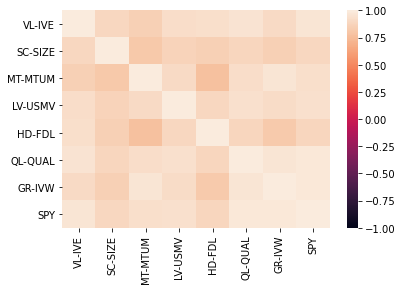

In [7]:
# return correlation, beta: positive correlation. High Dividend EFTs seems to correlated more 
correlation = funds_return.corr()
sns.heatmap(correlation, vmin =-1, vmax=1)

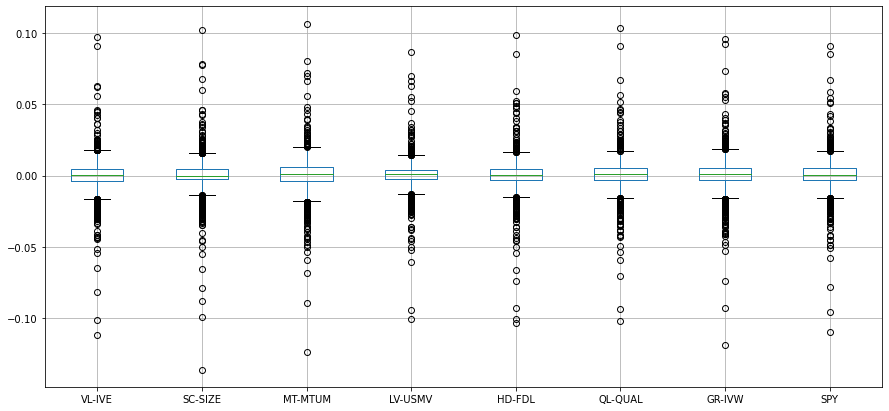

In [8]:
#distribution of returns
boxplot_return_dist = funds_return.boxplot(figsize = (15,7), grid = True)

Looking at fund's return volatility in the past 7 years, all active funds have similar vol as S&P except Low Vol fund which try to capture beta by low-volatile stick in nature. 

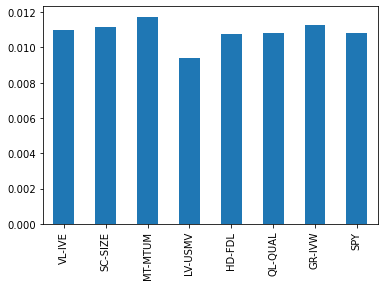

In [9]:
#long-term volatilityof return
funds_return_std = funds_return.std()
funds_return_std.plot(kind="bar")

In term of tradeoff between risk and return, Momentum(Sharpe ratio 1.26), Growth (1.28), Quality (1.04) and Low Vol (0.68) Funds offer better risk-adjusted return compared to S&P index(0.65). 

Active funds could outperform S&P by 4% annually. Annualized return from investing in S&P in the past 7 years is 10.29% (annualized return since inception). The best performer among active funds is Momentum (MT-MTUM) which generate annualized return at 14.60%. Follow by Growth (GR-IVW, 14.37%), Quality (QL-QUAL, 10.91%). Even Value funds underperform S&P but annualized return are still positive. Majority of High Dividend funds generate loss.

However, rank of performance change in recent shorter horizon. Outperformance of Momentum fund is pretty robust, except in the past 3 months that Momentum Fund (17.72%) underperform S&P (18.20%). Growth Fund (21.41%) and Small Cap Fund (20.72%) are the best performers in the past 3 months as propect of economic growth improved.

Growth fund is also performed slightly better than market index during tough time. Maximum Drawdown of Momentum fund is -34.08%, slightly than -34.10% of S&P index. However, MDD is shallower for HD-HYG (-28.05%). In contrast, MDD are deeper in HD-FDL (-41.40%) and HD-SDIV (-69.08%).

In [10]:
#backtesting
backtest = funds_df.calc_stats()
backtest.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18
End                  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17  2020-08-17
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         44.94%      79.96%      168.05%     90.58%      26.85%      108.00%     160.08%     100.11%
Daily Sharpe         0.39        0.56        0.84        0.69        0.28        0.69        0.85        0.66
Daily Sortino        0.58        0.81        1.28        1.03        0.42        1.05        1.28        0.98
CAGR                 5.38%       8.65%       14.94%      9.53%       3.41%       10.89%      14.45

Examine risk and return characteristics of passive and active funds in different economic/market scenarios in the past to get better idea how Momentum, Quality and Growth funds outperform market index. Given limitation of fund’s data which allow us to go back just 7 years, we set scenarios into 3 scenarios. (1) Taper Tantrum which represent the period of high market volatility in 2013  as investors feared that Fed will withdraw large amount of support in bond market and could increase funding rate. (2) Hike cycle in 2016-18  which represent period of good economic growth that Fed feel confident to increase policy rate. (3) Recent market turmoil during COVID pandemic which cause VIX index to spike in Mar. 

During Taper Tantrum period in 2013, Momentum (25.66% since incep ann) and Quality (30.10%) funds outperformed S&P (21.78%). Value fund (15.79-15.95%) turned out underperformed market index and were more volatile. Similar conclusion seen in pandemic scenario. Momentum (25.66%) also outperformed S&P (21.78%) during hiking cycle together with Low Vol (8.29%) and Growth (9.86%).

During market turmoil, Growth Fund has smallest MDD (-25.73%) and slightly lower than S&P (-28.74%).  

In [11]:
#economic cycle:cutting cycle(none),Taper Tantrum(2013), goldilock/hike cycle(2016-18), pandemic(Mar-May2020)
#slice return datafram into scenarios
funds_return_taper_tantrum = funds_return.loc['20130718':'20131231']
funds_return_hike_cycle = funds_return.loc['20160102':'20181231']
funds_return_pandemic = funds_return.loc['20200302':'20200330']
#slice price dataframe into scenarios
funds_df_taper_tantrum = funds_df.loc['20130718':'20131231']
funds_df_hike_cycle = funds_df.loc['20160102':'20181231']
funds_df_pandemic = funds_df.loc['20200302':'20200330']

In [12]:
#backtest funds during Taper Tantrum
backtest_taper_tantrum = funds_df_taper_tantrum.calc_stats()
backtest_taper_tantrum.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18  2013-07-18
End                  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31  2013-12-31
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         6.89%       8.45%       10.94%      4.87%       2.48%       12.70%      11.54%      9.37%
Daily Sharpe         1.49        1.81        2.34        1.19        0.63        2.84        2.48        2.04
Daily Sortino        2.81        2.82        4.35        2.42        1.11        5.04        4.66        3.81
CAGR                 15.79%      19.53%      25.66%      11.04%      5.54%       30.10%      27.17% 

In [13]:
#backtest funds during hiking cycle
backtest_hike_cycle = funds_df_hike_cycle.calc_stats()
backtest_hike_cycle.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04  2016-01-04
End                  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31  2018-12-31
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         15.61%      21.25%      39.58%      26.88%      15.87%      20.65%      32.46%      24.33%
Daily Sharpe         0.45        0.60        0.80        0.83        0.50        0.56        0.73        0.62
Daily Sortino        0.68        0.91        1.22        1.26        0.75        0.84        1.10        0.94
CAGR                 4.97%       6.66%       11.80%      8.29%       5.05%       6.48%       9.86% 

In [14]:
#backtest funds during pandemic
backtest_pandemic = funds_df_pandemic.calc_stats()
backtest_pandemic.display()

Stat                 VL-IVE      SC-SIZE     MT-MTUM     LV-USMV     HD-FDL      QL-QUAL     GR-IVW      SPY
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02  2020-03-02
End                  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30  2020-03-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         -18.21%     -20.07%     -13.34%     -14.37%     -21.83%     -14.13%     -12.98%     -15.35%
Daily Sharpe         -2.16       -2.24       -1.38       -1.86       -2.76       -1.62       -1.40       -1.81
Daily Sortino        -3.70       -3.60       -2.39       -3.20       -4.63       -2.90       -2.42       -3.09
CAGR                 -92.73%     -94.62%     -84.54%     -86.78%     -95.98%     -86.30%     -83

Interestingly, every funds correalted more with S&P during crisis time when volatiliry in the market spike. This could mean benefit of diversify among passive/active could become lower durinf crisis time.

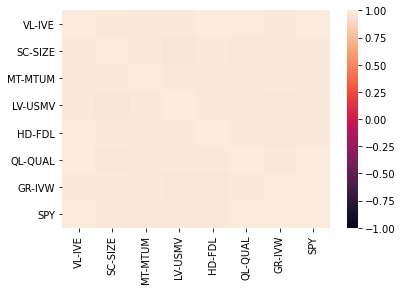

In [15]:
#correlation in different periods/cycle
correlation_pandemic = funds_return_pandemic.corr()
sns.heatmap(correlation_pandemic, vmin =-1, vmax=1)

In [16]:
funds_df.head(2)

VL-IVE    SC-SIZE    MT-MTUM    LV-USMV     HD-FDL    QL-QUAL  \
Date                                                                           
2013-07-18  79.949997  53.040001  54.110001  33.849998  21.379999  50.150002   
2013-07-19  80.230003  53.040001  54.349998  33.930000  21.430000  49.759998   

               GR-IVW         SPY  
Date                               
2013-07-18  88.529999  168.869995  
2013-07-19  88.500000  169.169998

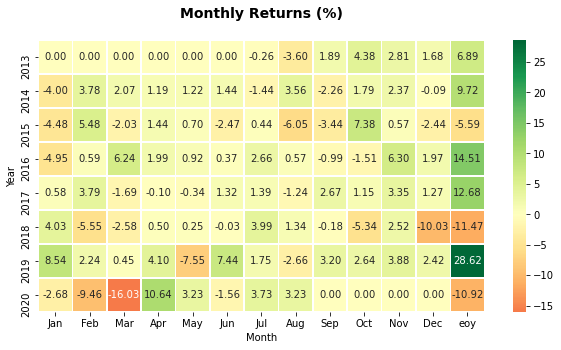

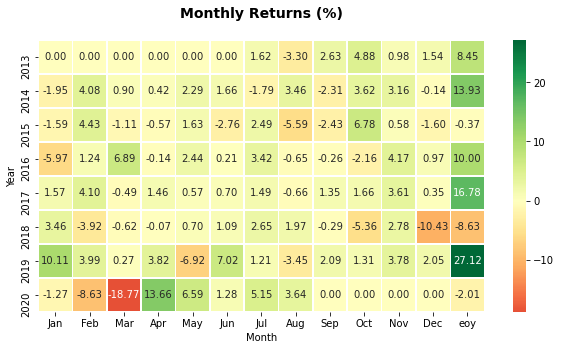

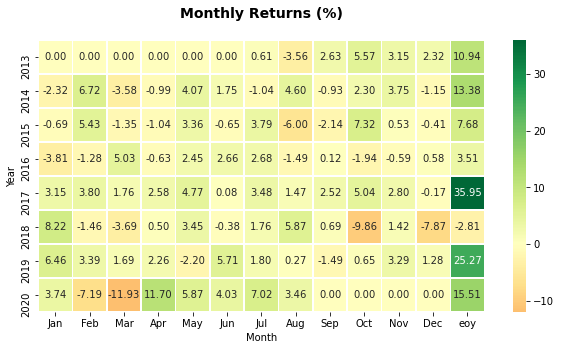

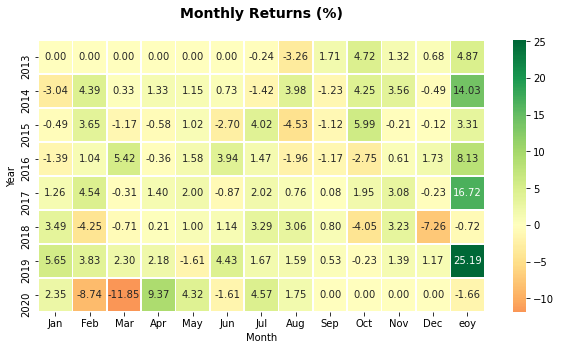

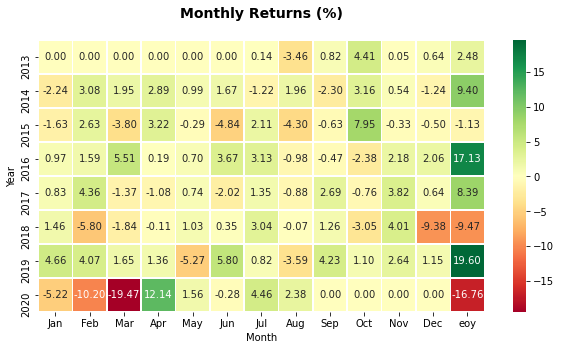

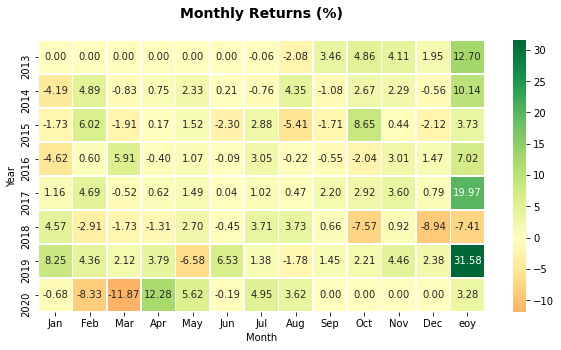

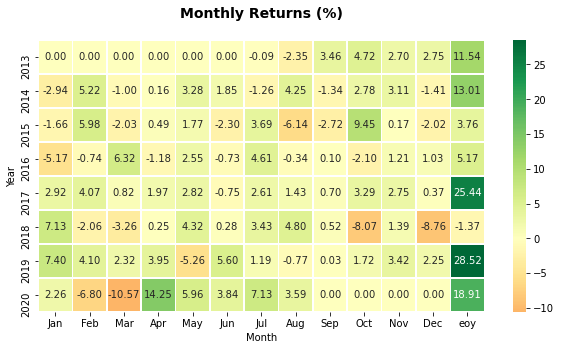

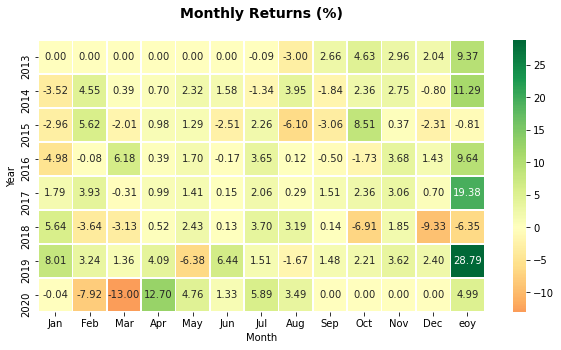

In [17]:
FoF_returns = funds_df.pct_change()
for column in FoF_returns:
    columnSeries = FoF_returns[column]
    mrh.plot(columnSeries, figsize=(10,5), eoy = True)

## Findings Summary

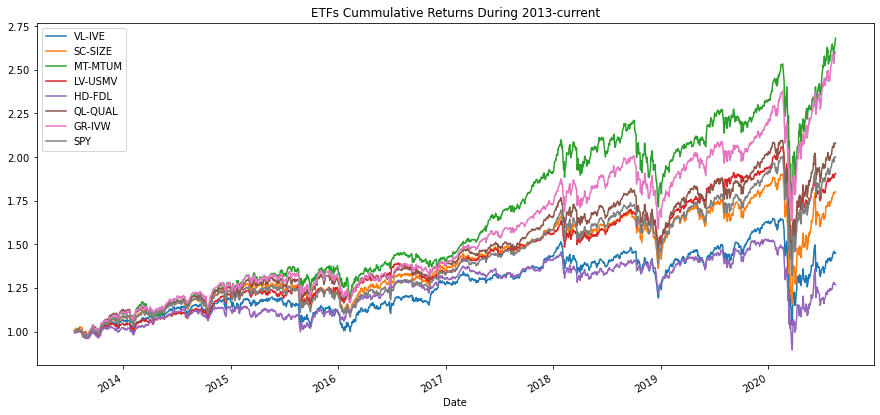

In [18]:
# Cummulative return: Growth, Momentum and Qualirty ETFs outperform SPY during 2013-current.
funds_return_cum = (1+funds_return).cumprod()
funds_return_cum.plot(figsize = (15,7), title = "ETFs Cummulative Returns During 2013-current")

### In term of tradeoff between risk and return, Momentum(Sharpe ratio 1.26), Growth (1.28), Quality (1.04) and Low Vol (0.68) Funds offer better risk-adjusted return compared to S&P index(0.65). 

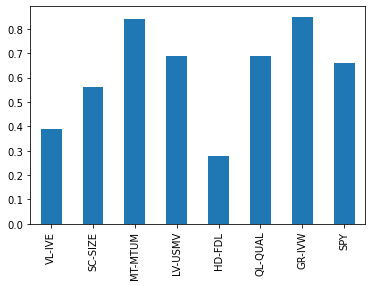

In [19]:
# Sharpe ratio: Risk/return tradeoff are less attractive in High Dividend funds. Most attractive in Momentum, Quality and Growth funds.
funds_return_sharpe = round((funds_return.mean()*252)/(funds_return.std() * np.sqrt(252)),2)
funds_return_sharpe.plot(kind="bar")

### Outperformance of Momentum fund is pretty robust under different scenarios, except in the past 3 months that Momentum Fund underperform S&P. Growth Fund and Small Cap Fund are the best performers in the past 3 months as propect of economic growth improved.

In [20]:
funds_df_3m = funds_df.loc['20200514':'20200814']
total_return_all = round(ffn.core.calc_total_return(funds_df)*100,2)
total_return_3m = round(ffn.core.calc_total_return(funds_df_3m)*100,2)
total_return_taper_tantrum = round(ffn.core.calc_total_return(funds_df_taper_tantrum)*100,2)
total_return_pandemic = round(ffn.core.calc_total_return(funds_df_pandemic)*100,2)
total_return_hike_cycle = round(ffn.core.calc_total_return(funds_df_hike_cycle)*100,2)
total_return_scenarios = pd.concat([total_return_all, total_return_3m, total_return_taper_tantrum,total_return_pandemic,total_return_hike_cycle], axis = 1,keys=['Total','Last 3M','Taper Tantum','Pandemic','Hike Cycle'])
total_return_scenarios

Total  Last 3M  Taper Tantum  Pandemic  Hike Cycle
VL-IVE    44.94    14.05          6.89    -18.21       15.61
SC-SIZE   79.96    20.72          8.45    -20.07       21.25
MT-MTUM  168.05    17.72         10.94    -13.34       39.58
LV-USMV   90.58    10.88          4.87    -14.37       26.88
HD-FDL    26.85    15.01          2.48    -21.83       15.87
QL-QUAL  108.00    15.81         12.70    -14.13       20.65
GR-IVW   160.08    21.41         11.54    -12.98       32.46
SPY      100.11    18.20          9.37    -15.35       24.33

### Less downside risk is seen in Growth Fund during market turmoil. However, every funds correalted more with S&P during crisis time when volatility in the market spike. This could mean benefit of diversify among passive/active could become lower durinf crisis time.

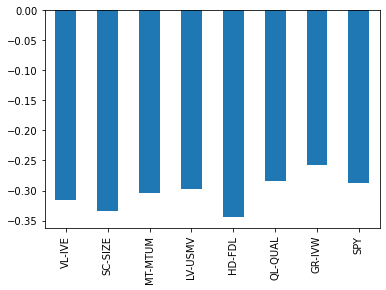

In [21]:
ffn.core.calc_max_drawdown(funds_df_pandemic).plot(kind="bar")

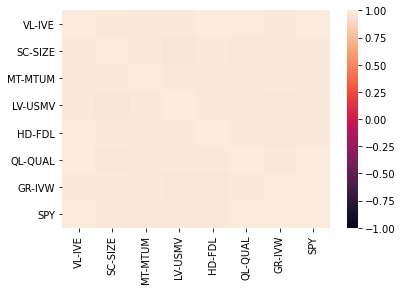

In [22]:
sns.heatmap(correlation_pandemic, vmin =-1, vmax=1)

# 3. Simulated Return and Portfolio Optimization

## Projected Return of Equal-Weight Portfolio

In [23]:
# Calculate the daily roi for the stocks
funds_return.head()

VL-IVE  SC-SIZE   MT-MTUM   LV-USMV    HD-FDL   QL-QUAL  \
Date                                                                    
2013-07-19  0.003502   0.0000  0.004435  0.002363  0.002339 -0.007777   
2013-07-22  0.002119   0.0181  0.001288  0.000295  0.000000  0.004823   
2013-07-23  0.000249   0.0000 -0.001654 -0.001178  0.003733 -0.001600   
2013-07-24 -0.006466   0.0000 -0.003497 -0.006490 -0.006973 -0.001402   
2013-07-25  0.002128   0.0000  0.007573  0.003860  0.004213  0.005216   

              GR-IVW       SPY  
Date                            
2013-07-19 -0.000339  0.001777  
2013-07-22  0.001808  0.001951  
2013-07-23 -0.003609 -0.002124  
2013-07-24 -0.001019 -0.003666  
2013-07-25  0.002946  0.002433

In [24]:
avg_daily_return = funds_return.mean()
avg_daily_return

VL-IVE     0.000269
SC-SIZE    0.000392
MT-MTUM    0.000622
LV-USMV    0.000406
HD-FDL     0.000192
QL-QUAL    0.000470
GR-IVW     0.000600
SPY        0.000448
dtype: float64

In [25]:
# Compute daily volatility
std_dev_daily_return = funds_return.std()
std_dev_daily_return

VL-IVE     0.011013
SC-SIZE    0.011136
MT-MTUM    0.011740
LV-USMV    0.009388
HD-FDL     0.010750
QL-QUAL    0.010826
GR-IVW     0.011261
SPY        0.010817
dtype: float64

In [26]:
std_dev_daily_return_fdl = funds_return.std()['HD-FDL']
std_dev_daily_return_fdl

0.010749824790623022

In [27]:
avg_daily_return_fdl = funds_return.mean()['HD-FDL']
avg_daily_return_fdl

0.00019157553133718582

In [28]:
std_dev_daily_return_ive = funds_return.std()['VL-IVE']
std_dev_daily_return_ive

0.011012639597596893

In [29]:
avg_daily_return_ive = funds_return.mean()['VL-IVE']
avg_daily_return_ive

0.0002691798134677326

In [30]:
std_dev_daily_return_ivw = funds_return.std()['GR-IVW']
std_dev_daily_return_ivw

0.011261091286647896

In [31]:
avg_daily_return_ivw = funds_return.mean()['GR-IVW']
avg_daily_return_ivw

0.0005999058952389614

In [32]:
std_dev_daily_return_mtum = funds_return.std()['MT-MTUM']
std_dev_daily_return_mtum

0.011739653172675725

In [33]:
avg_daily_return_mtum = funds_return.mean()['MT-MTUM']
avg_daily_return_mtum

0.0006223587482682637

In [34]:
std_dev_daily_return_qual = funds_return.std()['QL-QUAL']
std_dev_daily_return_qual

0.010825603559522739

In [35]:
avg_daily_return_qual = funds_return.mean()['QL-QUAL']
avg_daily_return_qual

0.00046958321433772095

In [36]:
std_dev_daily_return_size = funds_return.std()['SC-SIZE']
std_dev_daily_return_size

0.011136318554662347

In [37]:
avg_daily_return_size = funds_return.mean()['SC-SIZE']
avg_daily_return_size

0.000392243299431613

In [38]:
std_dev_daily_return_spy = funds_return.std()['SPY']
std_dev_daily_return_spy

0.010817071637871812

In [39]:
avg_daily_return_spy = funds_return.mean()['SPY']
avg_daily_return_spy

0.0004479561172724136

In [40]:
std_dev_daily_return_usmv = funds_return.std()['LV-USMV']
std_dev_daily_return_usmv

0.00938825205547279

In [41]:
avg_daily_return_usmv = funds_return.mean()['LV-USMV']
avg_daily_return_usmv

0.0004060210741652252

In [42]:
# Save the last day's closing price
hd_fdl_last_day_closing_price= funds_df['HD-FDL'][-1]
vl_ive_last_day_closing_price= funds_df['VL-IVE'][-1]
gr_ivw_last_day_closing_price= funds_df['GR-IVW'][-1]
mt_mtum_last_day_closing_price= funds_df['MT-MTUM'][-1]
ql_qual_last_day_closing_price= funds_df['QL-QUAL'][-1]
sc_size_last_day_closing_price= funds_df['SC-SIZE'][-1]
spy_last_day_closing_price= funds_df['SPY'][-1]
lv_usmv_last_day_closing_price= funds_df['LV-USMV'][-1]

In [43]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_trading_days = 252

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
monte_carlo_portfolio_cumulative_returns = pd.DataFrame()

In [44]:
# Run the Monte Carlo Simulation
for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price
    simulated_hd_fdl_prices = [hd_fdl_last_day_closing_price]
    simulated_vl_ive_prices = [vl_ive_last_day_closing_price]
    simulated_gr_ivw_prices = [gr_ivw_last_day_closing_price]
    simulated_mt_mtum_prices = [mt_mtum_last_day_closing_price]
    simulated_ql_qual_prices = [ql_qual_last_day_closing_price]
    simulated_sc_size_prices = [sc_size_last_day_closing_price]
    simulated_spy_prices = [spy_last_day_closing_price]
    simulated_lv_usmv_prices = [lv_usmv_last_day_closing_price]
    
    
    # Simulate the returns for 252 * 30 
    for i in range(number_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_hd_fdl_price = simulated_hd_fdl_prices[-1] * (1 + np.random.normal(avg_daily_return_fdl, std_dev_daily_return_fdl))
        simulated_vl_ive_price = simulated_vl_ive_prices[-1] * (1 + np.random.normal(avg_daily_return_ive, std_dev_daily_return_ive))
        simulated_gr_ivw_price = simulated_gr_ivw_prices[-1] * (1 + np.random.normal(avg_daily_return_ivw, std_dev_daily_return_ivw))
        simulated_mt_mtum_price = simulated_mt_mtum_prices[-1] * (1 + np.random.normal(avg_daily_return_mtum, std_dev_daily_return_mtum))
        simulated_ql_qual_price = simulated_ql_qual_prices[-1] * (1 + np.random.normal(avg_daily_return_qual, std_dev_daily_return_qual))
        simulated_sc_size_price = simulated_sc_size_prices[-1] * (1 + np.random.normal(avg_daily_return_size, std_dev_daily_return_size))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_lv_usmv_price = simulated_lv_usmv_prices[-1] * (1 + np.random.normal(avg_daily_return_usmv, std_dev_daily_return_usmv))
    
        
        # Append the simulated price to the list
        simulated_hd_fdl_prices.append(simulated_hd_fdl_price)
        simulated_vl_ive_prices.append(simulated_vl_ive_price)
        simulated_gr_ivw_prices.append(simulated_gr_ivw_price)
        simulated_mt_mtum_prices.append(simulated_mt_mtum_price)
        simulated_ql_qual_prices.append(simulated_ql_qual_price)
        simulated_sc_size_prices.append(simulated_sc_size_price)
        simulated_spy_prices.append(simulated_spy_price)
        simulated_lv_usmv_prices.append(simulated_lv_usmv_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df["HD-FDL"] = pd.Series(simulated_hd_fdl_prices)
    simulated_price_df["VL-IVE"] = pd.Series(simulated_vl_ive_prices)
    simulated_price_df["GR-IVW"] = pd.Series(simulated_gr_ivw_prices)
    simulated_price_df["MT-MTUM"] = pd.Series(simulated_mt_mtum_prices)
    simulated_price_df["QL-QUAL"] = pd.Series(simulated_ql_qual_prices)
    simulated_price_df["SC-SIZE"] = pd.Series(simulated_sc_size_prices)
    simulated_price_df["SPY"] = pd.Series(simulated_spy_prices)
    simulated_price_df["LV-USMV"] = pd.Series(simulated_lv_usmv_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (Equal weight)
    weights=[0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    monte_carlo_portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
   

In [45]:
simulated_price_df.head()

HD-FDL      VL-IVE      GR-IVW     MT-MTUM     QL-QUAL    SC-SIZE  \
0  27.120001  115.879997  230.250000  145.039993  104.309998  95.449997   
1  26.721413  116.067479  231.989727  147.495610  104.855242  94.709697   
2  26.867157  116.843595  234.397334  147.919572  105.159209  94.140431   
3  26.610261  116.266504  234.339290  146.255963  103.419478  94.917552   
4  26.617661  118.714765  236.933605  146.755139  102.699960  95.823491   

          SPY    LV-USMV  
0  337.920013  64.510002  
1  333.146202  64.016243  
2  337.971796  63.890412  
3  336.749992  63.664696  
4  337.376135  64.079847

In [46]:
# Check that the simulation ran successfully
monte_carlo_portfolio_cumulative_returns.tail()

0         1         2         3         4         5         6    \
248  1.182615  1.161531  1.104552  1.159706  1.108318  1.061280  1.129030   
249  1.182356  1.163317  1.104458  1.152334  1.112168  1.052788  1.134401   
250  1.186256  1.167779  1.102926  1.157893  1.104933  1.052303  1.142846   
251  1.184172  1.166934  1.102125  1.160201  1.100392  1.053340  1.139997   
252  1.188329  1.171006  1.102906  1.154308  1.094172  1.051902  1.141912   

          7         8         9    ...       490       491       492  \
248  1.160366  1.230630  1.128863  ...  1.047252  1.118044  1.016148   
249  1.165013  1.233335  1.129951  ...  1.041760  1.112943  1.015231   
250  1.162821  1.230557  1.131401  ...  1.041562  1.115793  1.010352   
251  1.162919  1.227587  1.125437  ...  1.044250  1.111839  1.010842   
252  1.159759  1.226222  1.122597  ...  1.044578  1.110090  1.010728   

          493       494       495       496       497       498       499  
248  1.131503  1.092132  1.068571  1.047127  1.021058  1.130309  1.072186  
249  1.130814  1.093940  1.068195  1.054355  1.013741  1.143061  1.070318  
250  1.131121  1.095607  1.068772  1.051844  1.008544  1.143778  1.072357  
251  1.132619  1.100941  1.065663  1.050691  1.007763  1.144916  1.074630  
252  1.132592  1.102784  1.069453  1.049839  1.008362  1.149536  1.074803  

[5 rows x 500 columns]

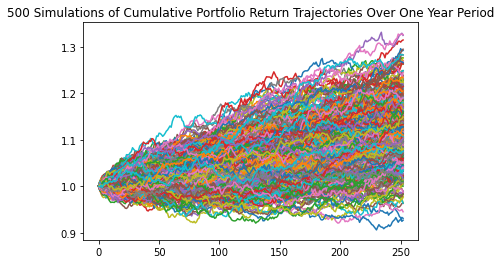

In [51]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over One Year Period"
monte_carlo_portfolio_cumulative_returns.plot(legend=None, title=plot_title)

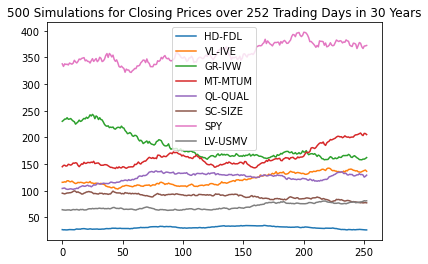

In [52]:
plot_title2=f"{number_simulations} Simulations for Closing Prices over {number_trading_days} Trading Days in 30 Years"
simulated_price_df.plot(title=plot_title2)

In [53]:
# last row for the cumulative returns
simulated_price_df[-1:]

HD-FDL     VL-IVE      GR-IVW     MT-MTUM     QL-QUAL   SC-SIZE  \
252  26.601685  136.56589  162.220874  205.347282  129.290125  77.37107   

            SPY    LV-USMV  
252  372.422891  81.188399

In [54]:
cumulative_ret = monte_carlo_portfolio_cumulative_returns.iloc[-1,:]

In [55]:
# Display the 90% confidence interval for the ending returns
confidence_interval= cumulative_ret.quantile(q=[0.05,0.95])
confidence_interval

0.05    1.012485
0.95    1.230439
Name: 252, dtype: float64

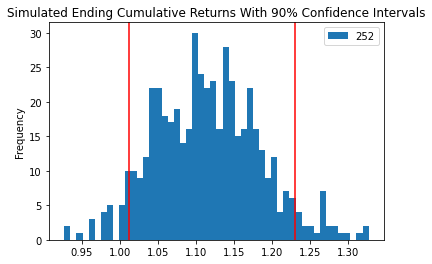

In [56]:
# Visualize the distribution of the ending returns
cumulative_ret.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval.iloc[0],color='r')
plt.axvline(confidence_interval.iloc[1],color='r')

## Optimization: Max Sharpe and Min Vol Portfolios

In [57]:
#Calculate mean returns and covariances of all stocks
funds_df = data['Close'].dropna()
funds_return = funds_df.pct_change().dropna()
mean_returns = funds_return.mean()
cov_matrix = funds_return.cov()
mean_returns
cov_matrix

FDL       IVE       IVW      MTUM      QUAL      SIZE       SPY  \
FDL   0.000116  0.000110  0.000100  0.000098  0.000103  0.000103  0.000104   
IVE   0.000110  0.000121  0.000113  0.000111  0.000114  0.000110  0.000115   
IVW   0.000100  0.000113  0.000127  0.000127  0.000118  0.000107  0.000119   
MTUM  0.000098  0.000111  0.000127  0.000138  0.000118  0.000107  0.000119   
QUAL  0.000103  0.000114  0.000118  0.000118  0.000117  0.000107  0.000115   
SIZE  0.000103  0.000110  0.000107  0.000107  0.000107  0.000124  0.000108   
SPY   0.000104  0.000115  0.000119  0.000119  0.000115  0.000108  0.000117   
USMV  0.000091  0.000096  0.000097  0.000100  0.000095  0.000091  0.000095   

          USMV  
FDL   0.000091  
IVE   0.000096  
IVW   0.000097  
MTUM  0.000100  
QUAL  0.000095  
SIZE  0.000091  
SPY   0.000095  
USMV  0.000088

In [58]:
# Compute daily volatility
std_return = funds_return.std()
std_return

FDL     0.010750
IVE     0.011013
IVW     0.011261
MTUM    0.011740
QUAL    0.010826
SIZE    0.011136
SPY     0.010817
USMV    0.009388
dtype: float64

In [59]:
#Set the number of iterations to 10000 and define an array to hold the simulation results; initially set to all zeros
num_iterations = 1000
simulation_res = np.zeros((4+len(stocks)-1,num_iterations))

In [60]:
#Compute stock returns and print the returns in percentage format
funds_return = funds_df.pct_change().dropna()
print (funds_return.round(4)*100)

             FDL   IVE   IVW  MTUM  QUAL  SIZE   SPY  USMV
Date                                                      
2013-07-19  0.23  0.35 -0.03  0.44 -0.78  0.00  0.18  0.24
2013-07-22  0.00  0.21  0.18  0.13  0.48  1.81  0.20  0.03
2013-07-23  0.37  0.02 -0.36 -0.17 -0.16  0.00 -0.21 -0.12
2013-07-24 -0.70 -0.65 -0.10 -0.35 -0.14  0.00 -0.37 -0.65
2013-07-25  0.42  0.21  0.29  0.76  0.52  0.00  0.24  0.39
...          ...   ...   ...   ...   ...   ...   ...   ...
2020-08-11 -0.18 -0.26 -1.18 -2.02 -0.50 -0.21 -0.83 -0.92
2020-08-12  0.40  0.73  1.91  2.71  1.25  0.66  1.39  1.02
2020-08-13 -0.84 -0.77  0.16  0.52 -0.24 -0.30 -0.18 -0.19
2020-08-14  0.15  0.26 -0.10 -0.08 -0.05  0.09  0.00  0.02
2020-08-17 -0.29 -0.26  0.59  1.82  0.31  0.25  0.32  0.47

[1783 rows x 8 columns]


In [61]:
for i in range(num_iterations):
#Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(8))
        weights /= np.sum(weights)
#Calculate the return and standard deviation for every step
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
#Store all the results in a defined array
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev
#Calculate Sharpe ratio and store it in the array
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
#Save the weights in the array
        for j in range(len(weights)):
                simulation_res[j+3,i] = weights[j]

In [62]:
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3], stocks[4], stocks[5], stocks[6], stocks[7]])
sim_frame.tail (5)

ret     stdev    sharpe       FDL       IVE       IVW      MTUM  \
995  0.000382  0.010256  0.037267  0.168958  0.124900  0.050350  0.005644   
996  0.000427  0.010403  0.041007  0.125778  0.175679  0.180470  0.122155   
997  0.000410  0.010329  0.039739  0.079460  0.195265  0.018580  0.134347   
998  0.000373  0.010212  0.036518  0.185764  0.185551  0.088847  0.031514   
999  0.000415  0.010419  0.039836  0.108447  0.196943  0.053676  0.184385   

         QUAL       SPY      USMV      SIZE  
995  0.187869  0.090714  0.186597  0.184967  
996  0.070704  0.014049  0.140108  0.171058  
997  0.187893  0.075993  0.110551  0.197910  
998  0.148579  0.138742  0.013349  0.207654  
999  0.068829  0.107779  0.144048  0.135892

In [63]:
#Spot the position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]
#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
print("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print("The portfolio for min risk:\n", min_std)

The portfolio for max Sharpe Ratio:
 ret       0.000527
stdev     0.010745
sharpe    0.049071
FDL       0.015179
IVE       0.000054
IVW       0.316164
MTUM      0.239289
QUAL      0.115279
SPY       0.089568
USMV      0.127676
SIZE      0.096791
Name: 634, dtype: float64
The portfolio for min risk:
 ret       0.000380
stdev     0.009887
sharpe    0.038466
FDL       0.244783
IVE       0.001022
IVW       0.017393
MTUM      0.036220
QUAL      0.249778
SPY       0.020209
USMV      0.003317
SIZE      0.427280
Name: 288, dtype: float64


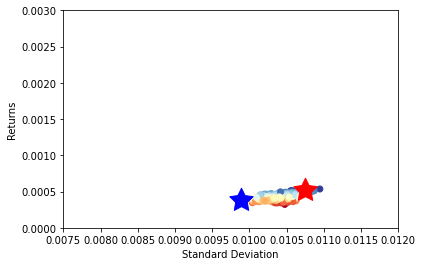

In [64]:
#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.ylim(0,.003)
plt.xlim(0.0075,0.012)
#Plot a red star to highlight position of the portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=600)
#Plot a blue star to highlight position of the portfolio with minimum Variance
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=600)
plt.show()

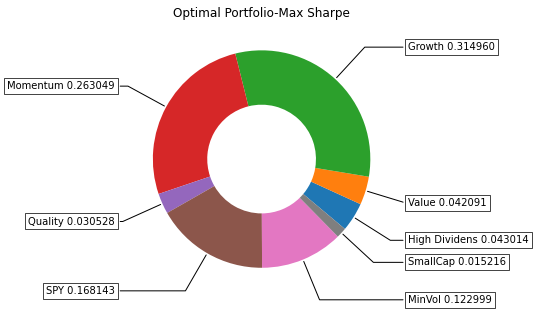

In [65]:
max_sharpe_w_pie , ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))

lebel = ["High Dividens 0.043014","Value 0.042091","Growth 0.314960","Momentum 0.263049","Quality 0.030528","SPY 0.168143","MinVol 0.122999","SmallCap 0.015216"]
        
data = [0.043014,0.042091,0.314960,0.263049,0.030528,0.168143,0.122999,0.015216]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(lebel[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Optimal Portfolio-Max Sharpe")

plt.show()

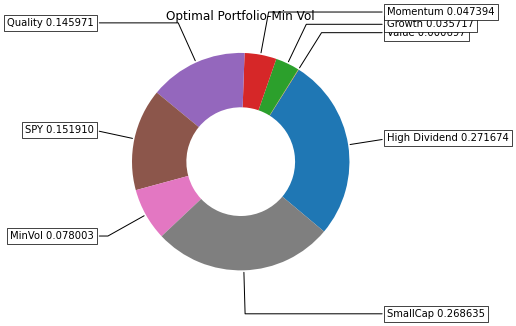

In [66]:
min_vol_w_pie, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))

lebel = ["High Dividend 0.271674","Value 0.000697","Growth 0.035717","Momentum 0.047394","Quality 0.145971","SPY 0.151910","MinVol 0.078003","SmallCap 0.268635"]
        
data = [0.271674,0.000697,0.035717,0.047394,0.145971,0.151910,0.078003,0.268635]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(lebel[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Optimal Portfolio-Min Vol")

plt.show()

## Projected Return of Max Sharpe Portfolio

In [67]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252
monte_carlo_max_sharpe = pd.DataFrame()
simulated_price_df_max_sharpe= pd.DataFrame()

In [69]:
# Run the Monte Carlo Simulation for Max Sharpe Port
# "FDL 0.043014","IVE 0.042091","IVW 0.314960","MTUM 0.263049","QUAL 0.030528","SPY 0.168143","USMV 0.122999","SIZE 0.015216"

for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price
    simulated_hd_fdl_prices = [hd_fdl_last_day_closing_price]
    simulated_vl_ive_prices = [vl_ive_last_day_closing_price]
    simulated_gr_ivw_prices = [gr_ivw_last_day_closing_price]
    simulated_mt_mtum_prices = [mt_mtum_last_day_closing_price]
    simulated_ql_qual_prices = [ql_qual_last_day_closing_price]
    simulated_sc_size_prices = [sc_size_last_day_closing_price]
    simulated_spy_prices = [spy_last_day_closing_price]
    simulated_lv_usmv_prices = [lv_usmv_last_day_closing_price]
    
    
    # Simulate the returns for 252
    for i in range(number_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_hd_fdl_price = simulated_hd_fdl_prices[-1] * (1 + np.random.normal(avg_daily_return_fdl, std_dev_daily_return_fdl))
        simulated_vl_ive_price = simulated_vl_ive_prices[-1] * (1 + np.random.normal(avg_daily_return_ive, std_dev_daily_return_ive))
        simulated_gr_ivw_price = simulated_gr_ivw_prices[-1] * (1 + np.random.normal(avg_daily_return_ivw, std_dev_daily_return_ivw))
        simulated_mt_mtum_price = simulated_mt_mtum_prices[-1] * (1 + np.random.normal(avg_daily_return_mtum, std_dev_daily_return_mtum))
        simulated_ql_qual_price = simulated_ql_qual_prices[-1] * (1 + np.random.normal(avg_daily_return_qual, std_dev_daily_return_qual))
        simulated_sc_size_price = simulated_sc_size_prices[-1] * (1 + np.random.normal(avg_daily_return_size, std_dev_daily_return_size))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_lv_usmv_price = simulated_lv_usmv_prices[-1] * (1 + np.random.normal(avg_daily_return_usmv, std_dev_daily_return_usmv))
    
        
        # Append the simulated price to the list
        simulated_hd_fdl_prices.append(simulated_hd_fdl_price)
        simulated_vl_ive_prices.append(simulated_vl_ive_price)
        simulated_gr_ivw_prices.append(simulated_gr_ivw_price)
        simulated_mt_mtum_prices.append(simulated_mt_mtum_price)
        simulated_ql_qual_prices.append(simulated_ql_qual_price)
        simulated_sc_size_prices.append(simulated_sc_size_price)
        simulated_spy_prices.append(simulated_spy_price)
        simulated_lv_usmv_prices.append(simulated_lv_usmv_price)
        
     
        
    simulated_price_df_max_sharpe["HD-FDL"]=simulated_hd_fdl_prices
    simulated_price_df_max_sharpe["VL-IVE"]=simulated_vl_ive_prices
    simulated_price_df_max_sharpe["GR-IVW"]=simulated_gr_ivw_prices
    simulated_price_df_max_sharpe["MT-MTUM"]=simulated_mt_mtum_prices
    simulated_price_df_max_sharpe["QL-QUAL"]=simulated_ql_qual_prices
    simulated_price_df_max_sharpe["SC-SIZE"]=simulated_sc_size_prices
    simulated_price_df_max_sharpe["SPY"]= simulated_spy_prices
    simulated_price_df_max_sharpe["LV-USMV"]=simulated_lv_usmv_prices
    
    simulated_daily_returns_max_sharpe=simulated_price_df_max_sharpe.pct_change()
    weights_max_sharpe=[0.043014,0.042091,0.314960,0.263049,0.030528,0.015216,0.168143,0.122999]
    portfolio_daily_returns_max_sharpe =simulated_daily_returns_max_sharpe.dot(weights_max_sharpe)
    monte_carlo_max_sharpe[simulations]= (1+portfolio_daily_returns_max_sharpe.fillna(0)).cumprod()
   

In [70]:
simulated_price_df_max_sharpe

HD-FDL      VL-IVE      GR-IVW     MT-MTUM     QL-QUAL    SC-SIZE  \
0    27.120001  115.879997  230.250000  145.039993  104.309998  95.449997   
1    26.792223  116.136953  230.731060  144.814944  102.433643  93.633052   
2    26.908130  115.233598  230.662457  145.948764  102.015260  94.718436   
3    27.127808  117.450002  230.813235  144.417393  101.722160  93.697517   
4    27.073063  118.770453  231.496952  144.123826  100.614183  95.277541   
..         ...         ...         ...         ...         ...        ...   
248  33.954596  112.149769  271.319250  151.623691  116.551402  86.537301   
249  33.248231  113.655927  276.842586  153.373922  117.562029  85.425634   
250  33.293664  110.148002  280.440395  151.354897  116.593102  85.320583   
251  33.340251  110.441380  281.303412  156.615462  118.373575  83.872159   
252  33.481415  111.445301  283.911962  156.109416  118.606730  83.314648   

            SPY    LV-USMV  
0    337.920013  64.510002  
1    337.309060  63.408708  
2    338.614285  64.158417  
3    336.715778  64.055224  
4    339.298909  64.012369  
..          ...        ...  
248  359.511079  65.944139  
249  352.919267  65.316167  
250  346.320016  64.794698  
251  345.405933  65.413639  
252  340.814004  64.525130  

[253 rows x 8 columns]

In [73]:
monte_carlo_max_sharpe[simulations].tail()

248    1.103179
249    1.108621
250    1.103071
251    1.115451
252    1.113988
Name: 0, dtype: float64

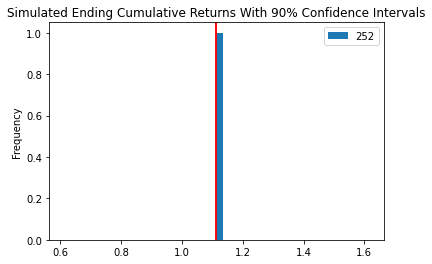

In [74]:
# Visualized projected Max Sharpe portfolio
cumulative_ret_max_sharpe = monte_carlo_max_sharpe.iloc[-1,:]
confidence_interval_max_sharpe= cumulative_ret_max_sharpe.quantile(q=[0.05,0.95])
cumulative_ret_max_sharpe.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval_max_sharpe.iloc[0],color='r')
plt.axvline(confidence_interval_max_sharpe.iloc[1],color='r')

In [75]:
confidence_interval_max_sharpe

0.05    1.113988
0.95    1.113988
Name: 252, dtype: float64

## Projected Return of Min Vol Portfolio

In [77]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252
monte_carlo_min_vol= pd.DataFrame()
simulated_price_df_min_vol= pd.DataFrame()

In [79]:
# Run the Monte Carlo Simulation for Max Sharpe Port
# "FDL 0.271674","IVE 0.000697","IVW 0.035717","MTUM 0.047394","QUAL 0.145971","SPY 0.151910","USMV 0.078003","SIZE 0.268635"

for n in range(number_simulations):

    # Initialize the simulated prices list with the last closing price
    simulated_hd_fdl_prices = [hd_fdl_last_day_closing_price]
    simulated_vl_ive_prices = [vl_ive_last_day_closing_price]
    simulated_gr_ivw_prices = [gr_ivw_last_day_closing_price]
    simulated_mt_mtum_prices = [mt_mtum_last_day_closing_price]
    simulated_ql_qual_prices = [ql_qual_last_day_closing_price]
    simulated_sc_size_prices = [sc_size_last_day_closing_price]
    simulated_spy_prices = [spy_last_day_closing_price]
    simulated_lv_usmv_prices = [lv_usmv_last_day_closing_price]
    
    
    # Simulate the returns for 252 
    for i in range(number_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_hd_fdl_price = simulated_hd_fdl_prices[-1] * (1 + np.random.normal(avg_daily_return_fdl, std_dev_daily_return_fdl))
        simulated_vl_ive_price = simulated_vl_ive_prices[-1] * (1 + np.random.normal(avg_daily_return_ive, std_dev_daily_return_ive))
        simulated_gr_ivw_price = simulated_gr_ivw_prices[-1] * (1 + np.random.normal(avg_daily_return_ivw, std_dev_daily_return_ivw))
        simulated_mt_mtum_price = simulated_mt_mtum_prices[-1] * (1 + np.random.normal(avg_daily_return_mtum, std_dev_daily_return_mtum))
        simulated_ql_qual_price = simulated_ql_qual_prices[-1] * (1 + np.random.normal(avg_daily_return_qual, std_dev_daily_return_qual))
        simulated_sc_size_price = simulated_sc_size_prices[-1] * (1 + np.random.normal(avg_daily_return_size, std_dev_daily_return_size))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_lv_usmv_price = simulated_lv_usmv_prices[-1] * (1 + np.random.normal(avg_daily_return_usmv, std_dev_daily_return_usmv))
    
        
        # Append the simulated price to the list
        simulated_hd_fdl_prices.append(simulated_hd_fdl_price)
        simulated_vl_ive_prices.append(simulated_vl_ive_price)
        simulated_gr_ivw_prices.append(simulated_gr_ivw_price)
        simulated_mt_mtum_prices.append(simulated_mt_mtum_price)
        simulated_ql_qual_prices.append(simulated_ql_qual_price)
        simulated_sc_size_prices.append(simulated_sc_size_price)
        simulated_spy_prices.append(simulated_spy_price)
        simulated_lv_usmv_prices.append(simulated_lv_usmv_price)
     
        
    simulated_price_df_min_vol["HD-FDL"]=simulated_hd_fdl_prices
    simulated_price_df_min_vol["VL-IVE"]=simulated_vl_ive_prices
    simulated_price_df_min_vol["GR-IVW"]=simulated_gr_ivw_prices
    simulated_price_df_min_vol["MT-MTUM"]=simulated_mt_mtum_prices
    simulated_price_df_min_vol["QL-QUAL"]=simulated_ql_qual_prices
    simulated_price_df_min_vol["SC-SIZE"]=simulated_sc_size_prices
    simulated_price_df_min_vol["SPY"]= simulated_spy_prices
    simulated_price_df_min_vol["LV-USMV"]=simulated_lv_usmv_prices
    
    simulated_daily_returns_min_vol=simulated_price_df_min_vol.pct_change()
    weights_min_vol=[0.271674,0.000697,0.035717,0.047394,0.145971,0.268635,0.151910,0.078003]
    portfolio_daily_returns_min_vol =simulated_daily_returns_min_vol.dot(weights_min_vol)
    monte_carlo_min_vol[simulations]= (1+portfolio_daily_returns_min_vol.fillna(0)).cumprod()
   

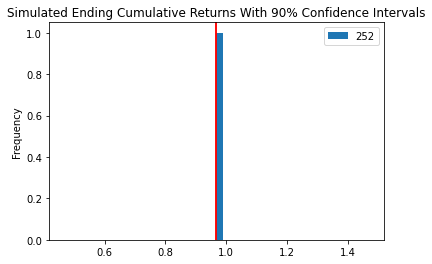

In [81]:
# Visualized projected Max Sharpe portfolio
cumulative_ret_min_vol = monte_carlo_min_vol.iloc[-1,:]
confidence_interval_min_vol= cumulative_ret_min_vol.quantile(q=[0.05,0.95])
cumulative_ret_min_vol.plot.hist(legend=True,bins=50, title="Simulated Ending Cumulative Returns With 90% Confidence Intervals")
plt.axvline(confidence_interval_min_vol.iloc[0],color='r')
plt.axvline(confidence_interval_min_vol.iloc[1],color='r')

In [82]:
confidence_interval_min_vol

0.05    0.967678
0.95    0.967678
Name: 252, dtype: float64

# 5. Data Insights/Reporting

## Tab 1: Passive vs Active Portfolios Performance

## Create Figures

In [83]:
funds_df.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_df = funds_df[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]
funds_return.columns = ["HD-FDL","VL-IVE","GR-IVW","MT-MTUM","QL-QUAL","SC-SIZE","SPY","LV-USMV"]
funds_return = funds_return[["VL-IVE","SC-SIZE","MT-MTUM","LV-USMV","HD-FDL","QL-QUAL","GR-IVW","SPY"]]

In [84]:
# Cummulative Return
funds_return_cum = (1+funds_return).cumprod()
cum_return_plot = px.line(funds_return_cum,title="Cummulative Return")

In [85]:
# Correlation
correlation = funds_return.corr()
correlation_pandemic = funds_return_pandemic.corr()
correlation_hike_cycle = funds_return_hike_cycle.corr()
correlation_taper_tantrum = funds_return_taper_tantrum.corr()
corr_plot = px.imshow(correlation,title="Correlation 2013-current")
corr_pandemic_plot = px.imshow(correlation_pandemic,title="Correlation Mar 2020")
corr_hike_cycle_plot = px.imshow(correlation_hike_cycle,title="Correlation 2016-18")
corr_taper_tantrum_plot = px.imshow(correlation_taper_tantrum,title="Correlation 2013")

In [86]:
# Return Performance
total_return_all = round(ffn.core.calc_total_return(funds_df)*100,2)
total_return_3m = round(ffn.core.calc_total_return(funds_df_3m)*100,2)
total_return_taper_tantrum = round(ffn.core.calc_total_return(funds_df_taper_tantrum)*100,2)
total_return_pandemic = round(ffn.core.calc_total_return(funds_df_pandemic)*100,2)
total_return_hike_cycle = round(ffn.core.calc_total_return(funds_df_hike_cycle)*100,2)
total_return_scenarios = pd.concat([total_return_3m, total_return_taper_tantrum,total_return_pandemic,total_return_hike_cycle], axis = 1,keys=['Last 3M','Taper Tantum','Pandemic','Hike Cycle']).reset_index()
return_scenarios_plot = total_return_scenarios.hvplot.bar(title="Annualized Return by Scenarios")

In [87]:
# Max DD
mdd=ffn.core.calc_max_drawdown(funds_df_pandemic)
mdd_plot = px.bar(mdd,title ="Maximum Drawdown")

In [88]:
# Sharpe
vol_plot = px.bar(funds_return_std,title="Return Volatility")
funds_return_sharpe = round((funds_return.mean()*252)/(funds_return.std() * np.sqrt(252)),2)
sharpe_plot = px.bar(funds_return_sharpe,title="Sharpe Ratio")

## Create panel

In [89]:
# Create row
tab1_row1 = pn.Row(cum_return_plot,mdd_plot)
tab1_row2 = pn.Row(return_scenarios_plot)
tab1_row3 = pn.Row(vol_plot,sharpe_plot)
tab1_row4 = pn.Row(corr_plot,corr_hike_cycle_plot)
tab1_row5 = pn.Row(corr_taper_tantrum_plot,corr_pandemic_plot)

In [90]:
#Create column for tab 1
tab1 = pn.Column(
    '# Evaluation of active funds vs passive fund (2013-current)',
    '## In performance space, Momentum fund, Growth Fund, and Quality Fund outperform S&P500 in the past 7 years. Growth Fund and Quality Fund have smaller MDD compared to S&P500.',tab1_row1,
    '## Outperformance of Momentum fund is pretty robust under different scenarios, except in the past 3 months that Momentum Fund underperform S&P. Growth Fund and Small Cap Fund are the best performers in the past 3 months as propect of economic growth ir improving. ',tab1_row2,
    '## In term of tradeoff between risk and return, Momentum, Growth, Quality and Low Vol Funds offer better risk-return trade off compared to S&P index.',tab1_row3,
    '## All active funds have positive correlation to S&P500',tab1_row4,
    '## However, every funds correalted more with S&P during crisis time when volatility in the market spike. This could mean benefit of diversifying among passive/active could become lower under this scenario.',tab1_row5,
    '### Disclaimer: Summary of evaluation is based on daily price data back to 2013.')
tab1

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [3] Markdown(str)
    [4] Row
        [0] HoloViews(Bars)
    [5] Markdown(str)
    [6] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [7] Markdown(str)
    [8] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [9] Markdown(str)
    [10] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [11] Markdown(str)

## Tab 2: Suggested Optimal Allocation

## Create Figures

In [91]:
#Histogram
equal_weight_hist = px.histogram(cumulative_ret, title="1Y Projected Return: Equal-weighted Portfilio")
max_sharpe_hist = px.histogram(cumulative_ret_max_sharpe, title="1Y Projected Return: Max-Sharpe Portfilio")
min_vol_hist = px.histogram(cumulative_ret_min_vol, title="1Y Projected Return: Min-Vol Portfilio")

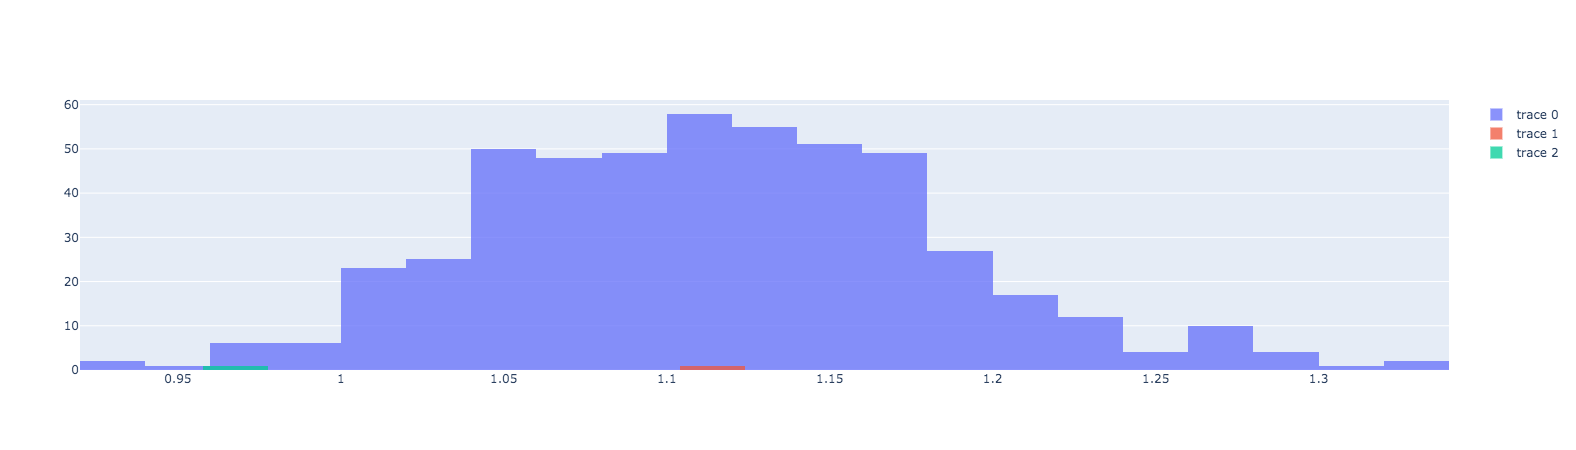

In [92]:
# Overlay histrogram
overlay_hist = go.Figure()
overlay_hist.add_trace(go.Histogram(x=cumulative_ret))
overlay_hist.add_trace(go.Histogram(x=cumulative_ret_max_sharpe))
overlay_hist.add_trace(go.Histogram(x=cumulative_ret_min_vol))
overlay_hist.update_layout(barmode='overlay')
overlay_hist.update_traces(opacity=0.75)

## Create panel

In [93]:
# Create row
tab2_row1 = max_sharpe_w_pie
tab2_row2 = min_vol_w_pie
tab2_row3 = pn.Row(equal_weight_hist,max_sharpe_hist,min_vol_hist)
tab2_row4 = pn.Row(overlay_hist)

Column
    [0] Markdown(str)
    [1] Markdown(str)
    [2] Matplotlib(Figure)
    [3] Markdown(str)
    [4] Matplotlib(Figure)
    [5] Markdown(str)
    [6] Row
        [0] Plotly(Figure)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [7] Markdown(str)
    [8] Row
        [0] Plotly(Figure)
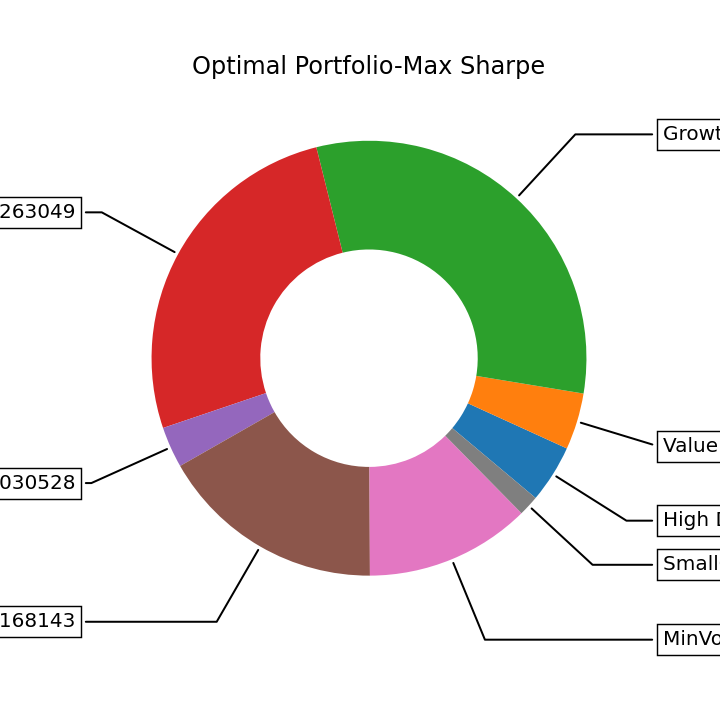
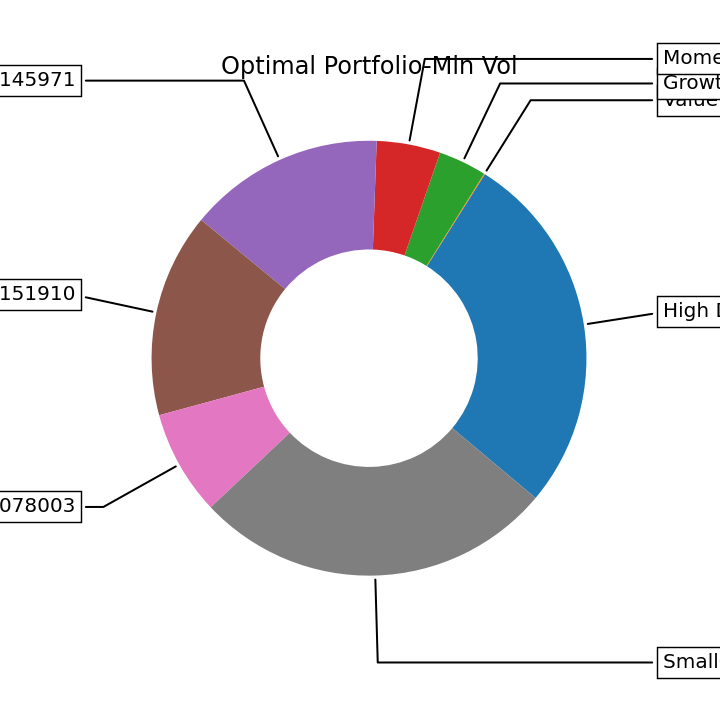

In [94]:
#Create column for tab 1
tab2 = pn.Column(
    '# Optimal Portfolio',
    '##Allocating more in Growth, Momentum and Quality funds yield optimal portfolio with maxmimum Sharpe ratio',tab2_row1,
    '##Meanwhile, allocating more in High Dividend fund give optimal portfolio with maxmimum Sharpe ratio',tab2_row2,
    '## ',tab2_row3,
    "## Compared to equal-weight portfoliom, Max-Sharpe portfolio can increase average return in 1Y-projected period while enhance upside gain. In contrast, Min-Vol would lower portfolio's volatiliry with the cost of lower return",tab2_row4)
tab2

# Data Dashboard

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [3] Markdown(str)
        [4] Row
            [0] HoloViews(Bars)
        [5] Markdown(str)
        [6] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [7] Markdown(str)
        [8] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [9] Markdown(str)
        [10] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
        [11] Markdown(str)
    [1] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Matplotlib(Figure)
        [3] Markdown(str)
        [4] Matplotlib(Figure)
        [5] Markdown(str)
        [6] Row
            [0] Plotly(Figure)
            [1] Plotly(Figure)
            [2] Plotly(Figure)
        [7] Markdown(str)
        [8] Row
            [0] Plotly(Figure)
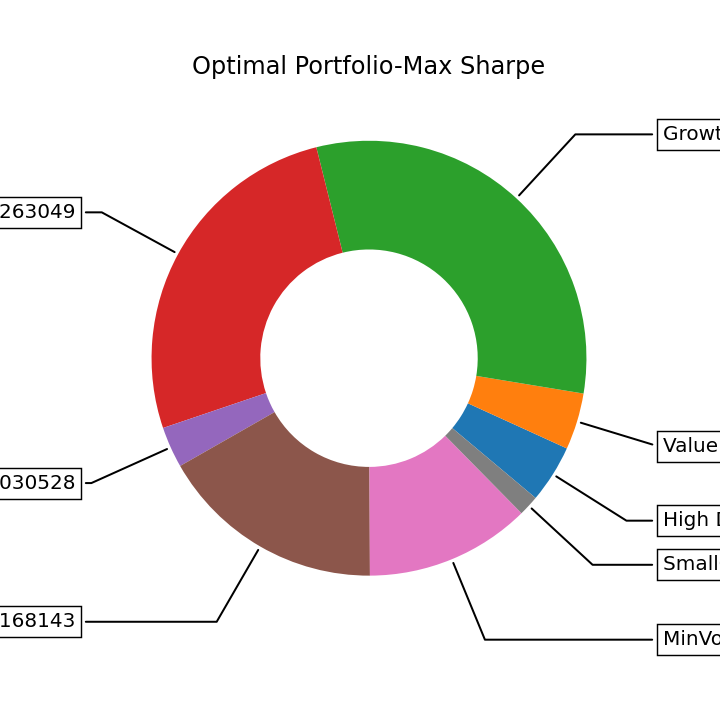
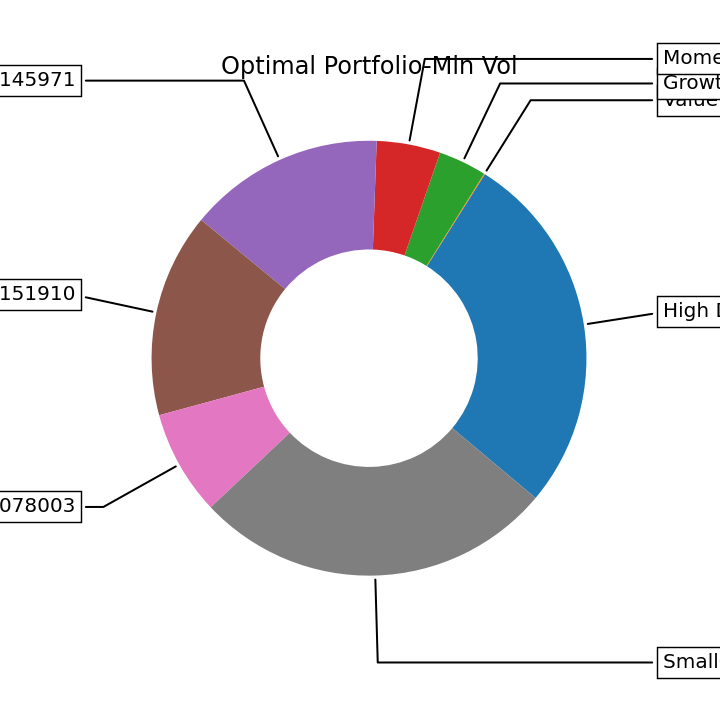

In [95]:
# Create tabs
tabs = pn.Tabs(
    ("Evaluation of active funds vs passive fund", tab1),
    ("Optimal Portfolio", tab2))
tabs